In [3]:
import os
import json
import csv
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Essential Dictionaries / lists

In [4]:
directory = '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt'

#get directories without hidden files
directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
directories.sort()

#Setup dictionary to collect file names
all_file_names = {}

#Identify all file names
for d in directories:
    #get file names without hidden files
    files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
    files.sort()
    all_file_names[d] = files

In [5]:
#Count the number of videos in each video type
#Determined by checking last number string on each image and
#checking if it matches '0001'
num_videos = {}
first_img_indexes = {}

for d in directories:
    video_count = 0
    num_images = len(all_file_names[d])
    for i in range(num_images):
        if all_file_names[d][i].split('.')[0].split('_')[-1] == '0001':
            video_count += 1
    num_videos[d] = video_count

In [6]:
#Print out summary results
print(f"{'dance':<9} | {'Num Images':<10} | {'Num Videos':<9}")
print("-"*35)
for k,v in all_file_names.items():
    print(f'{k:<9} | {len(v):<10} | {num_videos[k]}')

dance     | Num Images | Num Videos
-----------------------------------
ballet    | 22410      | 89
break     | 25622      | 95
cha       | 28098      | 98
flamenco  | 24755      | 88
foxtrot   | 23738      | 79
jive      | 29100      | 106
latin     | 24460      | 90
pasodoble | 26607      | 98
quickstep | 24036      | 82
rumba     | 27262      | 94
samba     | 25807      | 96
square    | 27453      | 97
swing     | 26337      | 95
tango     | 24020      | 80
tap       | 28541      | 95
waltz     | 24380      | 80


In [7]:
# getting the names of videos and adding them to a dictionary under the dance style they belong to
# video_names = {key=DanceStyle : value=[VideoName0, VideoName1, etc.]}
video_names = {}
for d in directories:
    dance_names = []
    for x in all_file_names[d]:
        sliced_name = x[0:-9]
        if sliced_name not in dance_names:
            dance_names.append(sliced_name)
    video_names[d] = dance_names

In [8]:
# Validation: should return 89
print(len(video_names['ballet']))

89


## Function: Number of people in a frame

In [9]:
def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

## Functions: Get body position & Body parts

In [10]:
def get_body_position_info(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close
    people= []

    for i,person in enumerate(j):
        #Set up list to collect person's body location
        person_i = []
        count = 0

        #add each body part position to the list
        for body_part in person:
            count+=1
            if count == 1: continue
            else: person_i.append(body_part[1])

        #Append entire list to list of people
        people.append(person_i)

    return people

In [11]:
def get_body_part_labels(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close()
    
    # Extract body part labels from the first person entry in the JSON file
    body_part_labels = [body_part[0] for body_part in j[0][1:]]
   
    return body_part_labels

In [12]:
# creating a dictionary to hold each video and all of its frames {video_name: [frame1, frame2, etc.]}
videos_ballet = {}
videos_tap = {}
videos_latin = {}

# looping through all dance styles
for d in directories:
    # dict to store avg number of people per video for 1 dance style
    vid_dict = {}
    
    if d == 'ballet':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct == 1:
                        file_list.append(file_path)
    
            
            vid_dict[p] = file_list
        videos_ballet = vid_dict

    if d == 'tap':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct == 1:
                        file_list.append(file_path)
    
            
            vid_dict[p] = file_list
        videos_tap = vid_dict

    if d == 'latin':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct == 1:
                        file_list.append(file_path)
    
            
            vid_dict[p] = file_list
        videos_latin = vid_dict


print("Number of selected files for ballet:", len(videos_ballet))
print("Number of selected files for tap:", len(videos_tap))
print("Number of selected files for tap:", len(videos_latin))

Number of selected files for ballet: 89
Number of selected files for tap: 95
Number of selected files for tap: 90


In [13]:
# making sure no null frames are present
videos_ballet = {k: v for k, v in videos_ballet.items() if len(v) != 0}
videos_tap = {k: v for k, v in videos_tap.items() if len(v) != 0}
videos_latin = {k: v for k, v in videos_latin.items() if len(v) != 0}

print("New Number of selected files for ballet:", len(videos_ballet))
print("New Number of selected files for tap:", len(videos_tap))
print("New Number of selected files for tap:", len(videos_latin))

New Number of selected files for ballet: 71
New Number of selected files for tap: 38
New Number of selected files for tap: 53


In [15]:
# SPLIT

X_train_ballet = []
X_test_ballet = []
X_train_tap = []
X_test_tap = []
X_train_latin = []
X_test_latin = []

# append 80% of keys (80% of the key count, but append the contents) to a list of X_train_ballet
split_b = int((len(videos_ballet)*80)/100)
b = 0

# v is the name of the video
# f is the files (with paths) in the video
for v, f in videos_ballet.items():
    if b <= split_b:
        b += 1
        X_train_ballet.append(f)
    else:
        X_test_ballet.append(f)

split_t = int((len(videos_tap)*80)/100)
t = 0

for v, f in videos_tap.items():
    if t <= split_t:
        t += 1
        X_train_tap.append(f)
    else:
        X_test_tap.append(f)

split_l = int((len(videos_latin)*80)/100)
l = 0

for v, f in videos_latin.items():
    if l <= split_l:
        l += 1
        X_train_latin.append(f)
    else:
        X_test_latin.append(f)

print('Ballet train set length:',len(X_train_ballet))
print('Ballet test set length:',len(X_test_ballet))
print('Tap train set length:',len(X_train_tap))
print('Tap test set length:',len(X_test_tap))
print('Latin train set length:',len(X_train_latin))
print('Latin test set length:',len(X_test_latin))

Ballet train set length: 57
Ballet test set length: 14
Tap train set length: 31
Tap test set length: 7
Latin train set length: 43
Latin test set length: 10


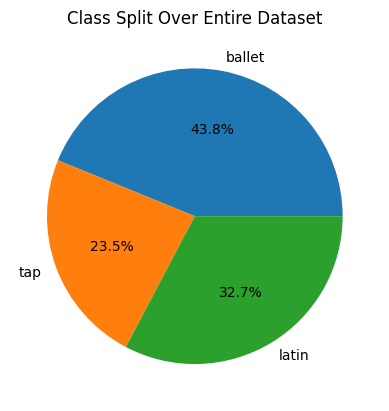

In [16]:
# sample size of data
l = np.array([len(videos_ballet), len(videos_tap), len(videos_latin)])
labels = ["ballet", "tap", "latin"]

plt.pie(l, labels = labels, autopct='%1.1f%%')
plt.title('Class Split Over Entire Dataset')
plt.show()

## Ballet, Latin, and Tap Model

In [17]:
# combine arrays
X_train_files = X_train_ballet + X_train_tap + X_train_latin
X_test_files = X_test_ballet + X_test_tap + X_test_latin

In [18]:
# Initialize lists to store feature data and corresponding labels
train_feature_data = []
train_feature_data_flattened = []

train_labels = []

# Iterate through each json file representing a frame in the training set
for file in X_train_files: 
    for f in file:
        #print('file is: ', file)
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(f)#[0]
        #print(body_positions)
        train_feature_data.append(body_positions)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
    
        # Append the flattened positions to the feature data list
        train_feature_data_flattened.append(flattened_positions)
        
        # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        elif 'tap' in f:
            label = 'tap'
        elif 'latin' in f:
            label = 'latin'
        else:
            label = 'unknown'
        train_labels.append(label)

In [19]:
# Convert the training feature data and labels into numpy arrays
X_train = np.array(train_feature_data)
X_train_flattened = np.array(train_feature_data_flattened)
y_train = np.array(train_labels)

print("Number of frames (rows) in X_train:", len(X_train_flattened))
print("Number of features (columns) in X_train:", len(X_train_flattened[0]))
print("Number of labels in y_train:", len(y_train))

Number of frames (rows) in X_train: 17235
Number of features (columns) in X_train: 17
Number of labels in y_train: 17235


In [20]:
y_train_split = np.unique(y_train, return_counts=True)

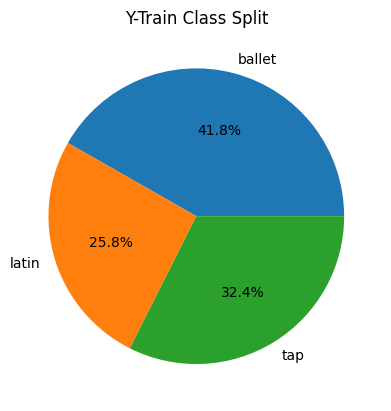

In [21]:
plt.pie(y_train_split[1], labels = y_train_split[0], autopct='%1.1f%%')
plt.title('Y-Train Class Split')
plt.show()

In [22]:
# repeating above steps for test data

# Initialize lists to store feature data and corresponding labels for the testing set
test_feature_data = []
test_labels = []

# Iterate through each JSON file representing a frame in the testing set
for file in X_test_files:
    for f in file:
        # Get body position info for the single person in the frame
        body_positions = get_body_position_info(f)
        
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
        
        # Append the flattened positions to the feature data list for the testing set
        test_feature_data.append(flattened_positions)
    
         # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        elif 'tap' in f:
            label = 'tap'
        elif 'latin' in f:
            label = 'latin'
        else:
            label = 'unknown'
        test_labels.append(label)

# Convert the testing feature data and labels into numpy arrays
X_test_flattened = np.array(test_feature_data)
y_test = np.array(test_labels)

print("Number of frames (rows) in X_test:", len(X_test_flattened))
print("Number of features (columns) in X_test:", len(X_test_flattened[0]))
print("Number of labels in y_test:", len(y_test))


Number of frames (rows) in X_test: 3549
Number of features (columns) in X_test: 17
Number of labels in y_test: 3549


In [23]:
y_test_split = np.unique(y_test, return_counts=True)

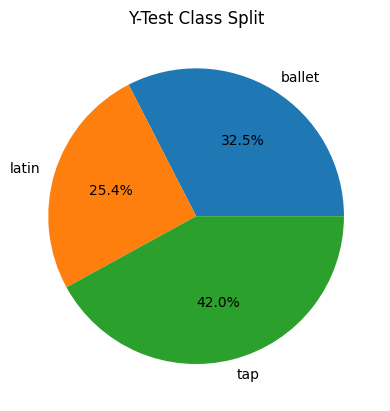

In [24]:
plt.pie(y_test_split[1], labels = y_test_split[0], autopct='%1.1f%%')
plt.title('Y-Test Class Split')
plt.show()

## Random Forest Model Construction

In [26]:
# then train and do the model

# prepping the model 
# Define the body part labels
body_part_labels = [
    "nose_x", "nose_y", 
    "left_eye_x", "left_eye_y", 
    "right_eye_x", "right_eye_y", 
    "left_ear_x", "left_ear_y", 
    "right_ear_x", "right_ear_y", 
    "left_shoulder_x", "left_shoulder_y", 
    "right_shoulder_x", "right_shoulder_y", 
    "left_elbow_x", "left_elbow_y", 
    "right_elbow_x", "right_elbow_y", 
    "left_wrist_x", "left_wrist_y", 
    "right_wrist_x", "right_wrist_y", 
    "left_hip_x", "left_hip_y", 
    "right_hip_x", "right_hip_y", 
    "left_knee_x", "left_knee_y", 
    "right_knee_x", "right_knee_y", 
    "left_ankle_x", "left_ankle_y", 
    "right_ankle_x", "right_ankle_y"
]

# Create a dictionary to map body part labels to column indices
body_part_mapping = {label: i for i, label in enumerate(body_part_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_flattened[:, body_part_mapping["left_eye_x"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_flattened[:, body_part_mapping["right_shoulder_y"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_flattened[:, [body_part_mapping["nose_x"], body_part_mapping["nose_y"]]]
# print(nose_coordinates)
print(len(nose_coordinates))

[[1013.27441406  452.57897949]
 [ 991.35424805  459.38430786]
 [ 951.18487549  502.49514771]
 ...
 [1242.47412109  351.35824585]
 [1277.63964844  527.89550781]
 [1258.07751465  529.67114258]]
17235
17235
17235


In [27]:
df_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=body_part_labels)
df_train['label'] = y_train
df_train

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,1012.275391,462.577545,1025.262573,452.578979,1013.274414,452.578979,1061.227295,462.577545,1012.275391,466.576965,...,713.541626,1142.147705,823.525818,1007.280273,850.521973,1210.080933,952.507385,1022.265564,1005.499756,ballet
1,993.350952,470.377930,1001.337769,460.383728,991.354248,459.384308,1035.281738,463.381989,1040.273438,464.381409,...,699.244995,1146.098755,823.173035,1014.316345,838.164307,1202.006470,962.092346,998.342712,997.072021,ballet
2,951.184875,512.494019,959.179932,502.495148,951.184875,502.495148,1000.154663,505.494812,959.179932,510.494232,...,737.468323,1140.068237,849.455505,973.171326,853.455017,1198.032471,984.440063,967.175049,994.438904,ballet
3,969.196716,620.896118,980.181335,601.907410,968.198120,603.906189,1021.124084,603.906189,968.198120,605.905029,...,793.793762,1140.956543,872.747009,919.266541,880.742249,1193.882446,987.678894,895.300049,1005.668274,ballet
4,993.960449,569.382507,1008.953491,559.395630,994.959961,557.398315,1047.935425,576.373291,992.960938,569.382507,...,776.109924,1143.890869,871.983521,944.983154,871.983521,1189.869507,986.832092,930.989685,987.830811,ballet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17230,821.630615,283.389069,827.609985,273.403320,810.668457,274.401886,834.585876,279.394775,791.733826,281.391907,...,435.172668,774.792358,552.006104,795.720093,535.030273,756.854309,660.850891,811.665039,661.849487,latin
17231,811.738220,288.584564,817.715027,276.594269,801.776917,277.593475,823.691833,283.588623,780.858093,283.588623,...,445.457611,776.873596,556.367859,776.873596,548.374329,758.943176,661.282959,757.947083,666.278931,latin
17232,1235.478394,361.337158,1241.474731,353.354034,1242.474121,351.358246,1244.472900,355.349792,1284.448608,354.351929,...,526.987305,1271.456421,640.747070,1270.457031,639.749146,1340.414551,740.536316,1324.424194,736.544739,latin
17233,1281.598145,533.884705,1279.618896,528.893738,1277.639648,527.895508,1280.608521,530.890076,1253.889038,531.888306,...,590.781616,1307.328003,590.781616,1215.294312,590.781616,1215.294312,590.781616,1215.294312,590.781616,latin


In [28]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)
print(X_train_flattened_reshaped.shape)
print(X_test_flattened_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

(17235, 34)
(3549, 34)
(17235,)
(3549,)


## Random Forest Model 1 (best)

In [29]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth = 3) 
#RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 3) Accuracy: 0.5790363482671175

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5790363482671175


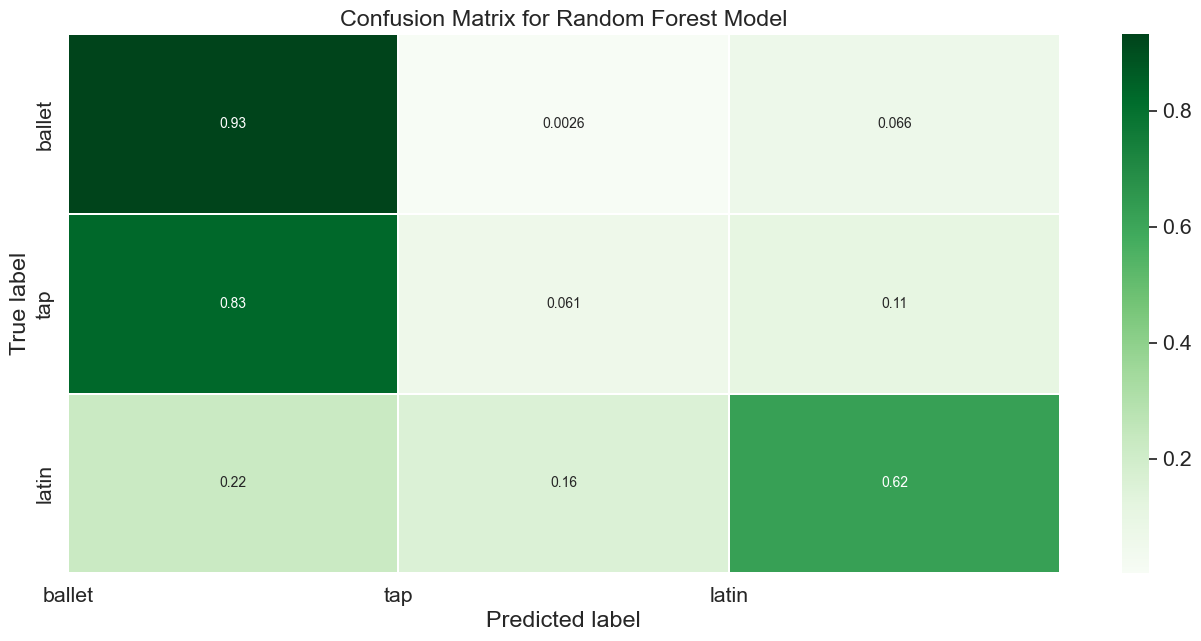

In [30]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'tap', 'latin']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [31]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ballet       0.50      0.93      0.65      1155
       latin       0.19      0.06      0.09       903
         tap       0.84      0.62      0.71      1491

    accuracy                           0.58      3549
   macro avg       0.51      0.54      0.48      3549
weighted avg       0.56      0.58      0.53      3549



## Gradient Boost Model

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100,max_depth=5)

# fit the model with the training data
model.fit(X_train_flattened_reshaped, y_train)

# predict the target on the train dataset
predict_test = model.predict(X_test_flattened_reshaped)
#print('\nTarget on train data',predict_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_train)


accuracy_score on test dataset :  0.5669202592279515


## Random Forest Model 2

In [33]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5122569737954353


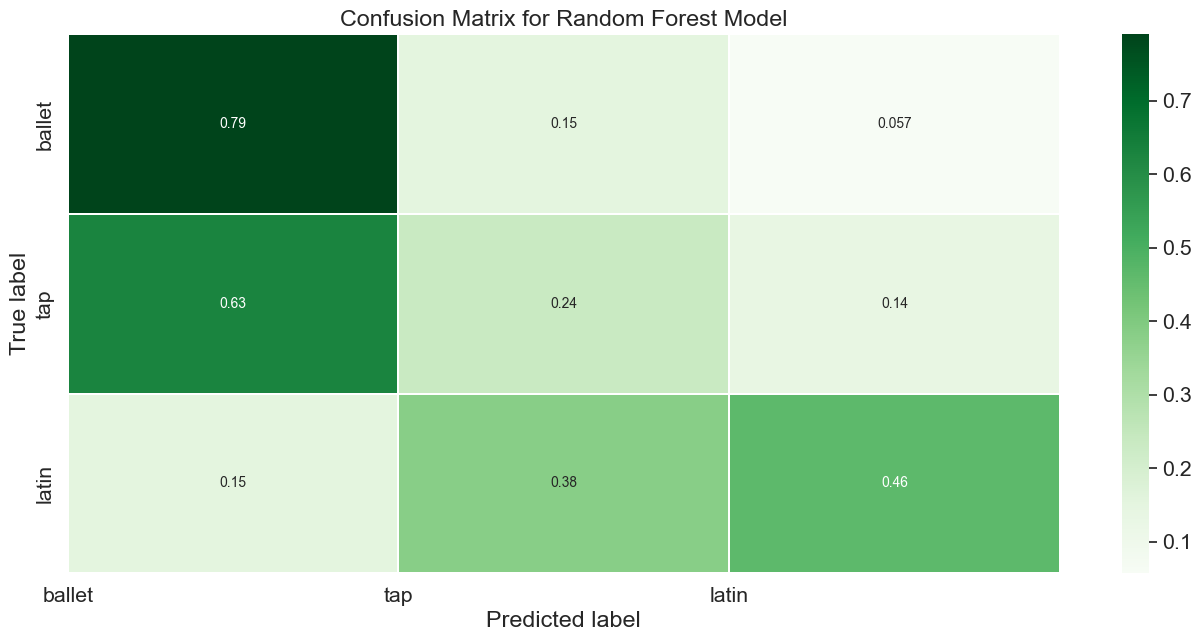

In [34]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'tap', 'latin']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [35]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ballet       0.53      0.79      0.64      1155
       latin       0.22      0.24      0.23       903
         tap       0.79      0.46      0.58      1491

    accuracy                           0.51      3549
   macro avg       0.51      0.50      0.48      3549
weighted avg       0.56      0.51      0.51      3549



From the above models, we can see that Tap and Ballet are most often confused. This could be due to the fact that ballet and tap have overlapping dance steps; with this theory in mind, we will try using a model on just Latin and Ballet and a model on Latin and Tap.

## Ballet and Latin 

In [67]:
# SPLIT

X_train_ballet = []
X_test_ballet = []
X_train_tap = []
X_test_tap = []
X_train_latin = []
X_test_latin = []

# append 80% of keys (80% of the key count, but append the contents) to a list of X_train_ballet
split_b = int((len(videos_ballet)*80)/100)
b = 0

# v is the name of the video
# f is the files (with paths) in the video
for v, f in videos_ballet.items():
    if b <= split_b:
        b += 1
        X_train_ballet.append(f)
    else:
        X_test_ballet.append(f)

#split_t = int((len(videos_tap)*80)/100)
#t = 0

#for v, f in videos_tap.items():
#    if t <= split_t:
#        t += 1
#        X_train_tap.append(f)
#    else:
#        X_test_tap.append(f)

split_l = int((len(videos_latin)*90)/100)
l = 0

for v, f in videos_latin.items():
    if l <= split_l:
        l += 1
        X_train_latin.append(f)
    else:
        X_test_latin.append(f)

print('Ballet train set length:',len(X_train_ballet))
print('Ballet test set length:',len(X_test_ballet))
print('Tap train set length:',len(X_train_tap))
print('Tap test set length:',len(X_test_tap))
print('Latin train set length:',len(X_train_latin))
print('Latin test set length:',len(X_test_latin))

Ballet train set length: 57
Ballet test set length: 14
Tap train set length: 0
Tap test set length: 0
Latin train set length: 48
Latin test set length: 5


In [68]:
# combine arrays
X_train_files = X_train_ballet + X_train_latin
X_test_files = X_test_ballet + X_test_latin

In [69]:
# Initialize lists to store feature data and corresponding labels
train_feature_data = []
train_feature_data_flattened = []

train_labels = []

# Iterate through each json file representing a frame in the training set
for file in X_train_files: 
    for f in file:
        #print('file is: ', file)
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(f)#[0]
        #print(body_positions)
        train_feature_data.append(body_positions)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
    
        # Append the flattened positions to the feature data list
        train_feature_data_flattened.append(flattened_positions)
        
        # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        #elif 'tap' in f:
        #    label = 'tap'
        elif 'latin' in f:
            label = 'latin'
        else:
            label = 'unknown'
        train_labels.append(label)

In [70]:
# Convert the training feature data and labels into numpy arrays
X_train = np.array(train_feature_data)
X_train_flattened = np.array(train_feature_data_flattened)
y_train = np.array(train_labels)

print("Number of frames (rows) in X_train:", len(X_train_flattened))
print("Number of features (columns) in X_train:", len(X_train_flattened[0]))
print("Number of labels in y_train:", len(y_train))

Number of frames (rows) in X_train: 12007
Number of features (columns) in X_train: 17
Number of labels in y_train: 12007


In [71]:
y_train_split = np.unique(y_train, return_counts=True)

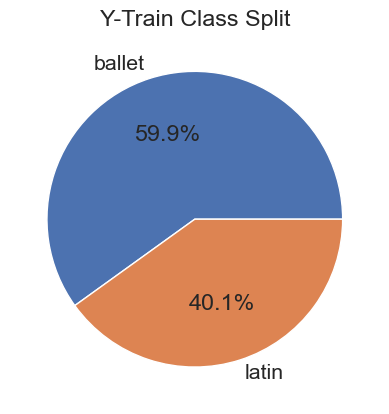

In [72]:
plt.pie(y_train_split[1], labels = y_train_split[0], autopct='%1.1f%%')
plt.title('Y-Train Class Split')
plt.show()

In [73]:
# repeating above steps for test data

# Initialize lists to store feature data and corresponding labels for the testing set
test_feature_data = []
test_labels = []

# Iterate through each JSON file representing a frame in the testing set
for file in X_test_files:
    for f in file:
        # Get body position info for the single person in the frame
        body_positions = get_body_position_info(f)
        
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
        
        # Append the flattened positions to the feature data list for the testing set
        test_feature_data.append(flattened_positions)
    
         # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        #elif 'tap' in f:
        #    label = 'tap'
        elif 'latin' in f:
            label = 'latin'
        else:
            label = 'unknown'
        test_labels.append(label)

# Convert the testing feature data and labels into numpy arrays
X_test_flattened = np.array(test_feature_data)
y_test = np.array(test_labels)

print("Number of frames (rows) in X_test:", len(X_test_flattened))
print("Number of features (columns) in X_test:", len(X_test_flattened[0]))
print("Number of labels in y_test:", len(y_test))


Number of frames (rows) in X_test: 1699
Number of features (columns) in X_test: 17
Number of labels in y_test: 1699


In [74]:
y_test_split = np.unique(y_test, return_counts=True)

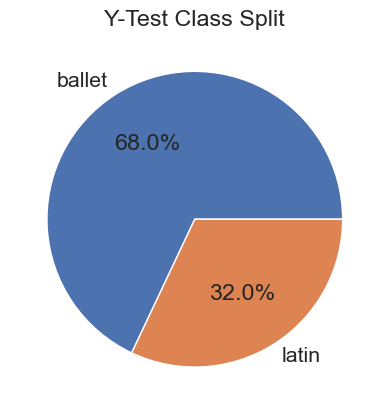

In [75]:
plt.pie(y_test_split[1], labels = y_test_split[0], autopct='%1.1f%%')
plt.title('Y-Test Class Split')
plt.show()

In [76]:
# then train and do the model

# prepping the model 
# Define the body part labels
body_part_labels = [
    "nose_x", "nose_y", 
    "left_eye_x", "left_eye_y", 
    "right_eye_x", "right_eye_y", 
    "left_ear_x", "left_ear_y", 
    "right_ear_x", "right_ear_y", 
    "left_shoulder_x", "left_shoulder_y", 
    "right_shoulder_x", "right_shoulder_y", 
    "left_elbow_x", "left_elbow_y", 
    "right_elbow_x", "right_elbow_y", 
    "left_wrist_x", "left_wrist_y", 
    "right_wrist_x", "right_wrist_y", 
    "left_hip_x", "left_hip_y", 
    "right_hip_x", "right_hip_y", 
    "left_knee_x", "left_knee_y", 
    "right_knee_x", "right_knee_y", 
    "left_ankle_x", "left_ankle_y", 
    "right_ankle_x", "right_ankle_y"
]

# Create a dictionary to map body part labels to column indices
body_part_mapping = {label: i for i, label in enumerate(body_part_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_flattened[:, body_part_mapping["left_eye_x"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_flattened[:, body_part_mapping["right_shoulder_y"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_flattened[:, [body_part_mapping["nose_x"], body_part_mapping["nose_y"]]]
# print(nose_coordinates)
print(len(nose_coordinates))

[[1013.27441406  452.57897949]
 [ 991.35424805  459.38430786]
 [ 951.18487549  502.49514771]
 ...
 [1055.78063965  303.78005981]
 [1038.28820801  291.19503784]
 [1047.0378418   300.20220947]]
12007
12007
12007


In [77]:
df_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=body_part_labels)
df_train['label'] = y_train
df_train

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,1012.275391,462.577545,1025.262573,452.578979,1013.274414,452.578979,1061.227295,462.577545,1012.275391,466.576965,...,713.541626,1142.147705,823.525818,1007.280273,850.521973,1210.080933,952.507385,1022.265564,1005.499756,ballet
1,993.350952,470.377930,1001.337769,460.383728,991.354248,459.384308,1035.281738,463.381989,1040.273438,464.381409,...,699.244995,1146.098755,823.173035,1014.316345,838.164307,1202.006470,962.092346,998.342712,997.072021,ballet
2,951.184875,512.494019,959.179932,502.495148,951.184875,502.495148,1000.154663,505.494812,959.179932,510.494232,...,737.468323,1140.068237,849.455505,973.171326,853.455017,1198.032471,984.440063,967.175049,994.438904,ballet
3,969.196716,620.896118,980.181335,601.907410,968.198120,603.906189,1021.124084,603.906189,968.198120,605.905029,...,793.793762,1140.956543,872.747009,919.266541,880.742249,1193.882446,987.678894,895.300049,1005.668274,ballet
4,993.960449,569.382507,1008.953491,559.395630,994.959961,557.398315,1047.935425,576.373291,992.960938,569.382507,...,776.109924,1143.890869,871.983521,944.983154,871.983521,1189.869507,986.832092,930.989685,987.830811,ballet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12002,1049.725220,388.816528,1061.722168,380.838837,1038.728027,379.841644,1070.719849,380.838837,1016.733704,317.017273,...,456.626953,1106.710571,531.417847,1103.711304,531.417847,1041.727295,596.236633,1057.723145,607.205933,latin
12003,1040.998535,309.371765,1038.010498,299.386932,1030.042236,299.386932,1072.871216,312.367249,1015.101929,310.370270,...,435.181000,1079.843384,521.050781,1105.739990,519.053833,1045.978638,590.944763,1065.899048,603.925110,latin
12004,1061.752686,309.779022,1043.836426,297.781128,1055.780640,303.780060,1006.013306,309.779022,1032.887695,305.779724,...,431.757690,1105.547974,515.742981,1102.561890,514.743164,1053.789917,586.730591,1068.720093,597.728699,latin
12005,1023.298828,315.182465,1040.286865,290.195557,1038.288208,291.195038,1048.281128,299.190826,1022.299500,319.180359,...,433.120575,1102.243042,515.077576,1101.243774,514.078064,1062.271240,594.036133,1063.270630,596.035095,latin


In [78]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)
print(X_train_flattened_reshaped.shape)
print(X_test_flattened_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

(12007, 34)
(1699, 34)
(12007,)
(1699,)


## Random Forest

In [83]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth = 3,  min_samples_leaf = 50) 
#when I have  an 80% data split on both ballet and latin datasets:
    # RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 3) Accuracy: 0.6448007774538387

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.711006474396704


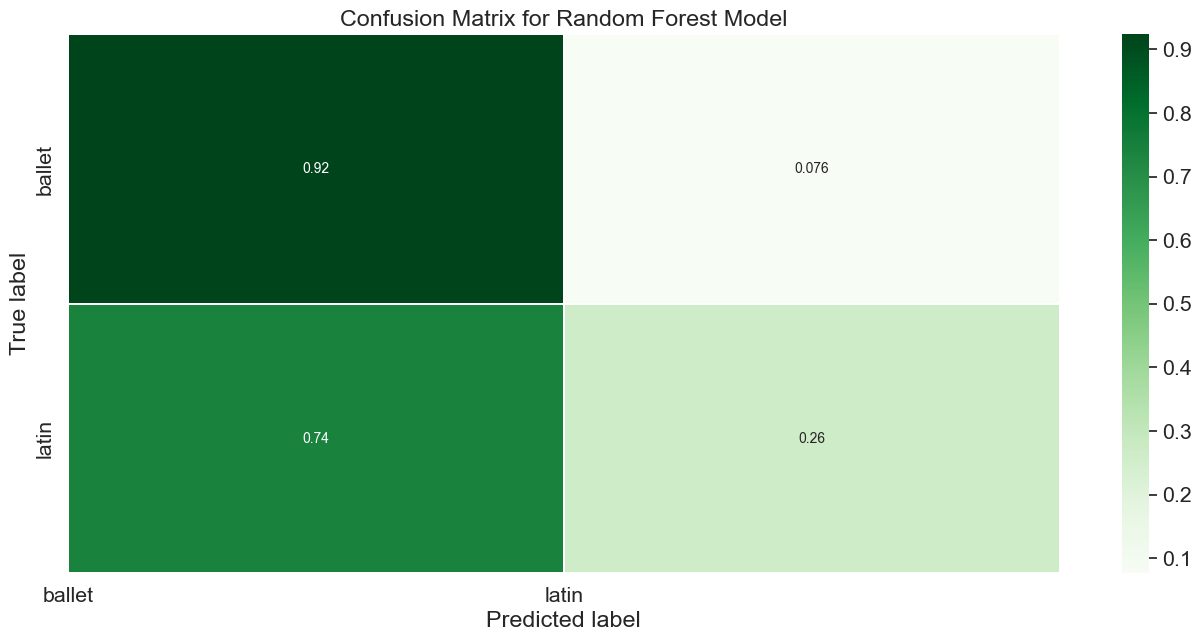

In [84]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'latin']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [86]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ballet       0.73      0.92      0.81      1155
       latin       0.62      0.26      0.36       544

    accuracy                           0.71      1699
   macro avg       0.67      0.59      0.59      1699
weighted avg       0.69      0.71      0.67      1699



## Gradient Boost Model

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_split = 500, min_samples_leaf = 50)

# fit the model with the training data
model.fit(X_train_flattened_reshaped, y_train)

# predict the target on the train dataset
predict_test = model.predict(X_test_flattened_reshaped)
#print('\nTarget on train data',predict_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_train)


accuracy_score on test dataset :  0.7010005885815186


## Basic Decision Tree

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train 
clf = clf.fit(X_train_flattened_reshaped,y_train)

#prediction on test data
y_pred = clf.predict(X_test_flattened_reshaped)

# accuracy score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.631547969393761
